In [1]:
#backtest 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, mean_squared_error, explained_variance_score, r2_score
import matplotlib.pyplot as plt

In [2]:
def data_string_to_float(number_string):
    """
    The result of our regex search is a number stored as a string, but we need a float.
        - Some of these strings say things like '25M' instead of 25000000.
        - Some have 'N/A' in them.
        - Some are negative (have '-' in front of the numbers).
        - As an artifact of our regex, some values which were meant to be zero are instead '>0'.
    We must process all of these cases accordingly.
    :param number_string: the string output of our regex, which needs to be converted to a float.
    :return: a float representation of the string, taking into account minus sign, unit, etc.
    """
    # Deal with zeroes and the sign
    if ("N/A" in number_string) or ("NaN" in number_string):
        return "N/A"
    elif number_string == ">0":
        return 0
    elif "B" in number_string:
        return float(number_string.replace("B", "")) * 1000000000
    elif "M" in number_string:
        return float(number_string.replace("M", "")) * 1000000
    elif "K" in number_string:
        return float(number_string.replace("K", "")) * 1000
    else:
        return float(number_string)

In [3]:
def duplicate_error_check(df):
    """
    A common symptom of failed parsing is when there are consecutive duplicate values. This function was used
    to find the duplicates and tweak the regex. Any remaining duplicates are probably coincidences.
    :param df: the dataframe to be checked
    :return: Prints out a list of the rows containing duplicates, as well as the duplicated values.
    """
    # Some columns often (correctly) have the same value as other columns. Remove these.
    df.drop(
        [
            "Unix",
            "Price",
            "stock_p_change",
            "SP500",
            "SP500_p_change",
            "Float",
            "200-Day Moving Average",
            "Short Ratio",
            "Operating Margin",
        ],
        axis=1,
        inplace=True,
    )

    for i in range(len(df)):
        # Check if there are any duplicates.
        if pd.Series(df.iloc[i] == df.iloc[i].shift()).any():
            duplicates = set(
                [x for x in list(df.iloc[i]) if list(df.iloc[i]).count(x) > 1]
            )
            # A duplicate value of zero is quite common. We want other duplicates.
            if duplicates != {0}:
                print(i, df.iloc[i], duplicates, sep="\n")

In [4]:
def status_calc(stock, sp500, outperformance=10):
    """A simple function to classify whether a stock outperformed the S&P500
    :param stock: stock price
    :param sp500: S&P500 price
    :param outperformance: stock is classified 1 if stock price > S&P500 price + outperformance
    :return: true/false
    """
    if outperformance < 0:
        raise ValueError("outperformance must be positive")
    return stock - sp500 >= outperformance

In [18]:
# Build the dataset, and drop any rows with missing values
backtest_df = pd.read_csv("ketstats_to_train.csv", index_col="calendardate")
backtest_df.dropna(axis=0, how="any", inplace=True)

features = backtest_df.columns[1:-4]
#X = backtest_df[features].values
X = pd.DataFrame(backtest_df[features])

# The labels are generated by applying the status_calc to the dataframe.
# '1' if a stock beats the S&P500 by more than x%, else '0'. Here x is the
# outperformance parameter, which is set to 10 by default but can be redefined.
y = pd.DataFrame(list(
        status_calc(
            backtest_df["stock_p_change"], backtest_df["sp500_p_change"], outperformance=10
        )
    ))

# z is required for us to track returns
z = np.array(backtest_df[["stock_p_change", "sp500_p_change"]])

# Generate the train set and test set by randomly splitting the dataset
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(
    X, y, z, test_size=0.1
)

# Instantiate a RandomForestClassifier with 100 trees, then fit it to the training data
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

# Generate the predictions, then print test set accuracy and precision
y_pred = clf.predict(X_test)
print("Classifier performance\n", "=" * 20)
print(f"Accuracy score: {clf.score(X_test, y_test): .2f}")
print(f"Precision score: {precision_score(y_test, y_pred): .2f}")

# Because y_pred is an array of 1s and 0s, the number of positive predictions
# is equal to the sum of the array
num_positive_predictions = sum(y_pred)
if num_positive_predictions < 0:
    print("No stocks predicted!")

# Recall that z_test stores the change in stock price in column 0, and the
# change in S&P500 price in column 1.
# Whenever a stock is predicted to outperform (y_pred = 1), we 'buy' that stock
# and simultaneously `buy` the index for comparison.
stock_returns = 1 + z_test[y_pred, 0] / 100
market_returns = 1 + z_test[y_pred, 1] / 100

# Calculate the average growth for each stock we predicted 'buy'
# and the corresponding index growth
avg_predicted_stock_growth = sum(stock_returns) / num_positive_predictions
index_growth = sum(market_returns) / num_positive_predictions
percentage_stock_returns = 100 * (avg_predicted_stock_growth - 1)
percentage_market_returns = 100 * (index_growth - 1)
total_outperformance = percentage_stock_returns - percentage_market_returns

print("\n Stock prediction performance report \n", "=" * 40)
print(f"Total Trades:", num_positive_predictions)
print(f"Average return for stock predictions: {percentage_stock_returns: .1f} %")
print(
    f"Average market return in the same period: {percentage_market_returns: .1f}% "
)
print(
    f"Compared to the index, our strategy earns {total_outperformance: .1f} percentage points more"
)

<ipython-input-18-330fb1fcabdc>:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Classifier performance
Accuracy score:  0.98
Precision score:  1.00

 Stock prediction performance report 
Total Trades: 2
Average return for stock predictions:  17.6 %
Average market return in the same period:  2.3% 
Compared to the index, our strategy earns  15.3 percentage points more


Root Mean Squared Error: 0.13099387894109052


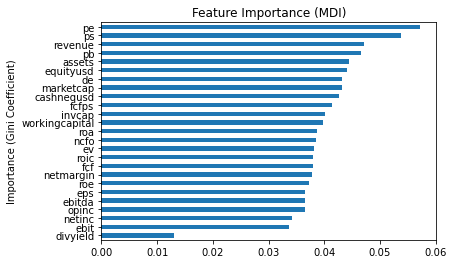

In [12]:
#Feature Importance
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.sort_values(inplace=True)
ax = feature_importances.plot.barh()
ax.set(ylabel='Importance (Gini Coefficient)', title='Feature importances');
ax.set_title('Feature Importance (MDI)')

#RMSE
print('Root Mean Squared Error:', 
      np.sqrt(mean_squared_error(y_test, y_pred)))

In [19]:
# The percentage by which a stock has to beat the S&P500 to be considered a 'buy'
OUTPERFORMANCE = 10

def build_data_set():
    """
    Reads the keystats.csv file and prepares it for scikit-learn
    :return: X_train and y_train numpy arrays
    """
    training_data = pd.read_csv("ketstats_to_train.csv", index_col="calendardate")
    training_data.dropna(axis=0, how="any", inplace=True)
    features = training_data.columns[1:-4]

    X_train = training_data[features].values
    # Generate the labels: '1' if a stock beats the S&P500 by more than 10%, else '0'.
    y_train = list(
        status_calc(
            training_data["stock_p_change"],
            training_data["sp500_p_change"],
            OUTPERFORMANCE,
        )
    )

    return X_train, y_train

def predict_stocks():
    X_train, y_train = build_data_set()
    # Remove the random_state parameter to generate actual predictions
    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_train, y_train)

    # Now we get the actual data from which we want to generate predictions.
    data = pd.read_csv("forward_sample.csv", index_col="calendardate")
    data.dropna(axis=0, how="any", inplace=True)
    features = data.columns[1:-4]
    X_test = data[features].values
    z = data["ticker"].values

    # Get the predicted tickers
    y_pred = clf.predict(X_test)
    if sum(y_pred) == 0:
        print("No stocks predicted!")
    else:
        invest_list = z[y_pred].tolist()
        print(
            f"{len(invest_list)} stocks predicted to outperform the S&P500 by more than {OUTPERFORMANCE}%:"
        )
        print(" ".join(invest_list))
        return invest_list

In [20]:
invest_list = predict_stocks()
invest_list

7 stocks predicted to outperform the S&P500 by more than 10%:
BE FMI STRP TWLO ZM SLP DKNG


['BE', 'FMI', 'STRP', 'TWLO', 'ZM', 'SLP', 'DKNG']

In [21]:
metadata = pd.read_csv("Tickers and Metadata.csv")
invest_list_metadata = metadata[metadata.ticker.isin(invest_list)]
invest_list_metadata[["ticker","name","category",
                      "sicindustry","scalemarketcap",
                      "scalerevenue","location"]]

,ticker,name,category,sicindustry,scalemarketcap,scalerevenue,location
1530,BE,Bloom Energy Corp,Domestic Common Stock,Electrical Industrial Apparatus,4 - Mid,3 - Small,California; U.S.A
3887,DKNG,DraftKings Inc,Domestic Common Stock Primary Class,Services-Miscellaneous Amusement & Recreation,5 - Large,2 - Micro,Massachusetts; U.S.A
5161,FMI,Foundation Medicine Inc,Domestic Common Stock,Services-Medical Laboratories,4 - Mid,2 - Micro,Massachusetts; U.S.A
